In [1]:
import sqlite3

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import base
from sklearn.model_selection import train_test_split
from sklearn import metrics, linear_model
from sklearn.neighbors import KNeighborsClassifier

from bokeh.charts import Line, Bar
from bokeh.io import output_notebook, show
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import Range1d, HoverTool

output_notebook()

Loading BokehJS ...

In [2]:
def postcode_formatter(postcode):
    if len(postcode) == 6:
        if postcode[0:4].isdigit() and postcode[4:6].isalpha():
            return postcode
    if len(postcode) == 7:
        if postcode[0:4].isdigit() and postcode[4:5] == ' ' and postcode[5:7].isalpha():
            return postcode[0:4] + postcode[5:7]
    raise Exception("Ongeldige postcode: " + postcode)

In [3]:
con = sqlite3.connect('data/verbruik.sqlite3')

# Voorspellen van netbeheerders aan de hand van longitude en latitude.

In [4]:
verbruik = pd.read_sql(
    "SELECT netbeheerder, postcode_van FROM verbruik where landcode = 'NL' and productsoort = 'ELK'",
    con
)

In [5]:
verbruik.dtypes

netbeheerder    object
postcode_van    object
dtype: object

In [6]:
verbruik.head()

,netbeheerder,postcode_van
0,Enexis B.V.,4251 AB
1,Enexis B.V.,4251 AC
2,Enexis B.V.,4251 AD
3,Enexis B.V.,4251 AE
4,Enexis B.V.,4251 AH


In [7]:
verbruik.shape

(2893607, 2)

In [8]:
verbruik['postcode_van'] = verbruik['postcode_van'].apply(postcode_formatter)

In [9]:
verbruik.head()

,netbeheerder,postcode_van
0,Enexis B.V.,4251AB
1,Enexis B.V.,4251AC
2,Enexis B.V.,4251AD
3,Enexis B.V.,4251AE
4,Enexis B.V.,4251AH


In [10]:
postcodetabel = pd.read_excel('data/postcodetabel.xlsx')

In [11]:
postcodetabel.head()

,PostcodeID,PostCodePK,PostCode,PostcodeNummers,PostcodeLetters,Straat,MinNummer,MaxNummer,Plaats,Gemeente,Provincie,Latitude,Longitude
0,1,6651EH_22,6651EH,6651,EH,Genechtstraat,22,32,Druten,Druten,Gelderland,51.887605,5.597723
1,2,1189WK_2,1189WK,1189,WK,De Wijde Blik,2,30,Amstelveen,Amstelveen,Noord-Holland,52.259021,4.869899
2,3,1065VL_3,1065VL,1065,VL,Jacob Geelstraat,3,11,Amsterdam,Amsterdam,Noord-Holland,52.362345,4.831505
3,4,8471RK_24,8471RK,8471,RK,Beatrixstraat,24,36,Wolvega,Weststellingwerf,Friesland,52.873527,5.996328
4,5,7231JH_78,7231JH,7231,JH,Breegraven,78,102,Warnsveld,Zutphen,Gelderland,52.138558,6.225588


In [12]:
postcodetabel = postcodetabel.drop(['PostcodeID', 'PostCodePK', 'PostcodeNummers',
         'PostcodeLetters', 'Straat', 'MinNummer',
         'MaxNummer', 'Plaats', 'Gemeente', 'Provincie'], 1)

In [13]:
verbruik_merged = pd.merge(verbruik, postcodetabel, how='inner', left_on='postcode_van', right_on='PostCode', copy=True)

In [14]:
verbruik_merged = verbruik_merged.drop(['postcode_van', 'PostCode'], 1)

verbruik_merged.head()

,netbeheerder,Latitude,Longitude
0,Enexis B.V.,51.814929,4.891426
1,Enexis B.V.,51.814929,4.891426
2,Enexis B.V.,51.814929,4.891426
3,Enexis B.V.,51.814929,4.891426
4,Enexis B.V.,51.814929,4.891426


In [15]:
verbruik_merged.dtypes

netbeheerder     object
Latitude        float64
Longitude       float64
dtype: object

In [16]:
netbeheerders = pd.read_sql(
    "SELECT distinct netbeheerder FROM verbruik where landcode = 'NL' and productsoort = 'ELK'",
    con
)

In [17]:
netbeheerders

,netbeheerder
0,Enexis B.V.
1,Enexis
2,Endinet
3,Liander N.V. (NW)
4,Liander N.V. (ZW)
5,Liander N.V.
6,8716874000009
7,8716892000005
8,8716946000005
9,8716925000002


In [18]:
netbeheerder_groepen = [['Enexis B.V.', 'Enexis'],
                        ['Endinet'],
                        ['Liander N.V. (NW)', 'Liander N.V. (ZW)', 'Liander N.V.'],
                        ['Cogas Infra & Beheer BV'],
                        ['8716902000001'],
                        ['8716912000008'],
                        ['8716874000009', '8716892000005', '8716946000005',
                         '8716925000002', '8716886000004', '8716921000006', '8716924000003'],
                        ['8716878999996']]

In [19]:
netbeheerder_namen = ['Enexis',
                     'Endinet',
                     'Liander',
                     'Cogas',
                     'Enduris',
                     'Rendo',
                     'Stedin',
                     'Westland']

In [20]:
def netbeheerder_formatter(netbeheerder):
    for i in range(len(netbeheerder_groepen)):
        if netbeheerder in netbeheerder_groepen[i]:
            return i
    print("Ongeldige netbeheerder: " + netbeheerder)
    return None

In [21]:
verbruik_merged['netbeheerder'] = verbruik_merged['netbeheerder'].apply(netbeheerder_formatter)

In [22]:
verbruik_merged.dtypes

netbeheerder      int64
Latitude        float64
Longitude       float64
dtype: object

In [23]:
verbruik_merged.head()

,netbeheerder,Latitude,Longitude
0,0,51.814929,4.891426
1,0,51.814929,4.891426
2,0,51.814929,4.891426
3,0,51.814929,4.891426
4,0,51.814929,4.891426


In [24]:
target = verbruik_merged['netbeheerder'].as_matrix()
target

array([0, 0, 0, ..., 5, 5, 5], dtype=int64)

In [25]:
data = verbruik_merged.as_matrix(columns = ['Latitude', 'Longitude'])
data

array([[ 51.81492888,   4.89142581],
       [ 51.81492888,   4.89142581],
       [ 51.81492888,   4.89142581],
       ..., 
       [ 52.72768611,   6.53590956],
       [ 52.68373995,   6.54505911],
       [ 52.78189227,   6.15285175]])

In [26]:
x_train, x_test, y_train, y_test = train_test_split(data, target,
                                                    test_size=0.003, train_size=0.01, random_state=4)

Hieronder wordt bepaald hoe accuraat het algoritme is om de netbeheerder te bepalen aan de hand van de features longitude en latitude.

In [27]:
knn = KNeighborsClassifier(n_neighbors=200)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
acc = metrics.accuracy_score(y_test, y_pred)
print(acc)

0.953975848713


Zoals gezien kan worden is het algoritme erg accuraat, dit komt waarschijnlijk door de grote dataset.

# Gaat er meer stroom terug in het netwerk van de energiemaatschappijen de afgelopen vijf jaar?

In [28]:
sjv_terug = pd.read_sql(
    "select jaar, round(sum(((100 - leveringsrichting_perc)/100) * sjv_gemiddeld)) sjv_terug from verbruik where jaar < 2017 group by jaar order by jaar",
    con
)

In [29]:
sjv_terug = sjv_terug.set_index(['jaar'])

In [30]:
plot = Line(sjv_terug, title='Geleverde energie', xlabel='Jaar', ylabel='kWh', legend=False)

show(plot)

# Heeft er, in de loop van de tijd, een verplaatsing van gas naar elektriciteit plaatsgevonden?

In [31]:
verbruik = pd.read_sql("SELECT jaar, productsoort, round(sum(sjv_gemiddeld)) sjv_gemiddeld FROM verbruik " +
                            "where jaar >= 2011 and jaar <= 2016 " +
                            "group by productsoort, jaar", con)
verbruik['sjv_gemiddeld'] = verbruik["sjv_gemiddeld"].astype(int)
verbruik

,jaar,productsoort,sjv_gemiddeld
0,2011,ELK,1568265765
1,2012,ELK,1586851852
2,2013,ELK,1641406107
3,2014,ELK,1619658505
4,2015,ELK,1570359450
5,2016,ELK,1545931574
6,2011,GAS,572823775
7,2012,GAS,580764270
8,2013,GAS,604763934
9,2014,GAS,607243726


In [32]:
elk = verbruik[verbruik['productsoort'] == 'ELK']
elk = elk.rename(columns={'sjv_gemiddeld': 'ELK'})

gas = verbruik[verbruik['productsoort'] == 'GAS']
gas = gas.rename(columns={'sjv_gemiddeld': 'GAS'})

resultaten = pd.merge(elk, gas, how='inner', on='jaar')

resultaten = resultaten.set_index(['jaar'])
resultaten.index.name = None
resultaten = resultaten[['ELK', 'GAS']]

In [33]:
resultaten

,ELK,GAS
2011,1568265765,572823775
2012,1586851852,580764270
2013,1641406107,604763934
2014,1619658505,607243726
2015,1570359450,583972803
2016,1545931574,571386651


In [34]:
# Maak kolommen voor de chart
col = []
[col.append(i) for i in resultaten.columns]

# Maak een figure aan, geef metadata
p = figure(x_axis_type="linear", title="Gas(m³) vs. Elektriciteit (kWh)", width = 800, height = 450)
p.xaxis.axis_label = 'Jaar'
p.yaxis.axis_label = 'm³, kWh'

# Geef kleuren aan de lijnen
p.line(resultaten.index, resultaten['GAS'], legend = 'GAS', color = 'brown' )
p.line(resultaten.index, resultaten['ELK'], legend = 'ELK', color = 'yellow' )

# Zet range van de y_axis
p.y_range = Range1d(0, 1750000000)

# Laat de chart zien
show(p)

# Conclusie

Zoals in de tabel en de grafiek te zien is vindt er niet echt een overgang plaats van gasverbruik naar elektrisch verbruik. De verdeling blijft ongeveer hetzelfde.

# Zijn er in de afgelopen jaren meer slimme meters bijgekomen?

In [35]:
gegevens = pd.read_sql("SELECT * FROM verbruik where productsoort = 'ELK' and slimme_meter_perc >= 0", con)

In [36]:
gegevens.head()

,id,netbeheerder,netgebied,straatnaam,postcode_van,postcode_tot,woonplaats,landcode,productsoort,leveringsrichting_perc,aansluitingen_aantal,fysieke_status_perc,soort_aansluiting_perc,soort_aansluiting,sjv_gemiddeld,sjv_laag_tarief_perc,slimme_meter_perc,jaar
0,1,Enexis B.V.,ENEXIS,Sasdijk,4251 AB,4251 AB,WERKENDAM,NL,ELK,100.0,15.0,100.0,47.0,1x25,4728.0,29.0,7.0,2016
1,3,Enexis B.V.,ENEXIS,Sasdijk,4251 AC,4251 AC,WERKENDAM,NL,ELK,80.0,10.0,100.0,60.0,1x25,3908.0,33.0,20.0,2016
2,5,Enexis B.V.,ENEXIS,Sasdijk,4251 AD,4251 AD,WERKENDAM,NL,ELK,100.0,29.0,100.0,41.0,3x25,3850.0,30.0,14.0,2016
3,7,Enexis B.V.,ENEXIS,Nieuweweg,4251 AE,4251 AG,WERKENDAM,NL,ELK,95.0,21.0,100.0,48.0,1x25,4751.0,52.0,14.0,2016
4,9,Enexis B.V.,ENEXIS,Koppenhof,4251 AH,4251 AH,WERKENDAM,NL,ELK,100.0,13.0,100.0,38.0,1x25,3084.0,31.0,23.0,2016


In [37]:
gegevens2 = gegevens.copy()

In [38]:
gegevens2 = gegevens2.groupby(gegevens2['jaar']).mean()
gegevens2

,id,leveringsrichting_perc,aansluitingen_aantal,fysieke_status_perc,soort_aansluiting_perc,sjv_gemiddeld,sjv_laag_tarief_perc,slimme_meter_perc
jaar,,,,,,,,
2009,2728171,99.715297,23.361758,97.178178,88.873686,4582.214233,48.406451,2.449453
2010,2058833,99.767595,22.848621,97.932825,88.298165,4702.653474,43.842333,1.899810
2011,2260661,99.731843,22.970291,97.740472,74.636873,4698.240972,46.779112,2.190027
2012,2461867,99.656592,23.133028,97.608098,74.232932,4712.914257,46.947176,3.258346
2013,2744730,99.155431,23.227937,97.438043,74.110462,4652.903361,47.936302,5.174643
2014,2932071,97.764000,23.301352,96.849054,73.901272,4590.869255,47.148852,9.160902
2015,3134597,96.864290,23.379942,96.648292,73.646637,4434.725325,48.164893,14.068804
2016,2921795,95.657956,23.490386,96.420142,72.788697,4347.949327,51.302306,20.722785
2017,2861159,96.439705,22.880868,97.170805,71.236586,2586.602581,39.113453,20.060249


In [39]:
gegevens2 = gegevens2.drop([2009, 2017])

In [40]:
chart = Bar(gegevens2, title='Aantal slimme meters over de jaren', xlabel='Jaar', ylabel='Totaal slimme meters')
show(chart)

In [41]:
gegevens3 = gegevens.copy()

In [42]:
gegevens3 = gegevens3.drop(['id', 'leveringsrichting_perc', 'aansluitingen_aantal', 'fysieke_status_perc',
                            'soort_aansluiting_perc', 'sjv_gemiddeld', 'sjv_laag_tarief_perc'], axis=1)

In [43]:
gegevens3

,netbeheerder,netgebied,straatnaam,postcode_van,postcode_tot,woonplaats,landcode,productsoort,soort_aansluiting,slimme_meter_perc,jaar
0,Enexis B.V.,ENEXIS,Sasdijk,4251 AB,4251 AB,WERKENDAM,NL,ELK,1x25,7.00,2016
1,Enexis B.V.,ENEXIS,Sasdijk,4251 AC,4251 AC,WERKENDAM,NL,ELK,1x25,20.00,2016
2,Enexis B.V.,ENEXIS,Sasdijk,4251 AD,4251 AD,WERKENDAM,NL,ELK,3x25,14.00,2016
3,Enexis B.V.,ENEXIS,Nieuweweg,4251 AE,4251 AG,WERKENDAM,NL,ELK,1x25,14.00,2016
4,Enexis B.V.,ENEXIS,Koppenhof,4251 AH,4251 AH,WERKENDAM,NL,ELK,1x25,23.00,2016
5,Enexis B.V.,ENEXIS,Plein,4251 AJ,4251 AJ,WERKENDAM,NL,ELK,1x25,4.00,2016
6,Enexis B.V.,ENEXIS,Zevenhuizen,4251 AK,4251 AN,WERKENDAM,NL,ELK,1x25,20.00,2016
7,Enexis B.V.,ENEXIS,Zagerij,4251 AP,4251 AT,WERKENDAM,NL,ELK,1x25,13.00,2016
8,Enexis B.V.,ENEXIS,Sluisstraat,4251 AV,4251 AV,WERKENDAM,NL,ELK,1x25,43.00,2016
9,Enexis B.V.,ENEXIS,Prins Clausplein,4251 AW,4251 BB,WERKENDAM,NL,ELK,3x25,6.00,2016


In [44]:
gegevens3 = gegevens3.groupby(['netbeheerder', 'jaar']).mean()
gegevens3

slimme_meter_perc
netbeheerder      jaar                   
8716874000009     2009           3.765631
                  2010           3.914252
                  2011           4.108650
                  2012           4.346063
                  2013           5.031314
                  2014           9.727917
                  2015          13.162799
                  2016          26.267281
8716878999996     2009           0.000000
                  2010           0.000000
                  2011           0.000000
                  2012           0.003166
                  2013           3.658849
                  2014           6.697011
                  2015          11.115791
                  2016          24.493925
8716886000004     2009           6.966150
                  2010           7.970350
                  2011           8.104589
                  2012           8.412767
                  2013           8.612373
                  2014          10.334856
                  2015          13.320042
                  2016          22.754106
8716892000005     2009           3.657403
                  2010           4.373926
                  2011           4.576567
                  2012           4.719819
                  2013           5.263375
                  2014           7.981399
...                                   ...
Enexis B.V.       2015          18.895667
                  2016          24.809843
                  2017          38.212942
Liander N.V.      2009           2.441682
                  2010           2.551447
                  2011           3.075237
                  2012           4.170958
                  2013           4.135854
                  2014           7.903476
                  2015          11.678407
                  2016          16.570236
                  2017           4.135691
Liander N.V. (NW) 2009           0.000000
                  2010           0.023357
                  2011           0.231597
                  2012           0.966330
                  2013           4.577071
                  2014           7.863248
                  2015          11.107708
                  2016          16.789300
                  2017           4.577071
Liander N.V. (ZW) 2009           4.460394
                  2010           4.728322
                  2011           4.837207
                  2012           5.205757
                  2013           3.975142
                  2014           7.351365
                  2015          11.355352
                  2016          15.689221
                  2017           3.975142

[115 rows x 1 columns]

# In welke provincie is het gemiddelde verbruik per huishouden het hoogst?

In [45]:
gegevens = pd.read_sql("SELECT * FROM verbruik where productsoort = 'ELK' and slimme_meter_perc >= 0", con)

In [46]:
postcodes = pd.read_excel('data/postcodetabel.xlsx')

In [47]:
gegevens.head()

,id,netbeheerder,netgebied,straatnaam,postcode_van,postcode_tot,woonplaats,landcode,productsoort,leveringsrichting_perc,aansluitingen_aantal,fysieke_status_perc,soort_aansluiting_perc,soort_aansluiting,sjv_gemiddeld,sjv_laag_tarief_perc,slimme_meter_perc,jaar
0,1,Enexis B.V.,ENEXIS,Sasdijk,4251 AB,4251 AB,WERKENDAM,NL,ELK,100.0,15.0,100.0,47.0,1x25,4728.0,29.0,7.0,2016
1,3,Enexis B.V.,ENEXIS,Sasdijk,4251 AC,4251 AC,WERKENDAM,NL,ELK,80.0,10.0,100.0,60.0,1x25,3908.0,33.0,20.0,2016
2,5,Enexis B.V.,ENEXIS,Sasdijk,4251 AD,4251 AD,WERKENDAM,NL,ELK,100.0,29.0,100.0,41.0,3x25,3850.0,30.0,14.0,2016
3,7,Enexis B.V.,ENEXIS,Nieuweweg,4251 AE,4251 AG,WERKENDAM,NL,ELK,95.0,21.0,100.0,48.0,1x25,4751.0,52.0,14.0,2016
4,9,Enexis B.V.,ENEXIS,Koppenhof,4251 AH,4251 AH,WERKENDAM,NL,ELK,100.0,13.0,100.0,38.0,1x25,3084.0,31.0,23.0,2016


In [48]:
gegevens2 = gegevens.copy()
gegevens2['postcode_van'] = gegevens2['postcode_van'].apply(postcode_formatter)
gegevens2['postcode_tot'] = gegevens2['postcode_tot'].apply(postcode_formatter)

In [49]:
gegevens2.head()

,id,netbeheerder,netgebied,straatnaam,postcode_van,postcode_tot,woonplaats,landcode,productsoort,leveringsrichting_perc,aansluitingen_aantal,fysieke_status_perc,soort_aansluiting_perc,soort_aansluiting,sjv_gemiddeld,sjv_laag_tarief_perc,slimme_meter_perc,jaar
0,1,Enexis B.V.,ENEXIS,Sasdijk,4251AB,4251AB,WERKENDAM,NL,ELK,100.0,15.0,100.0,47.0,1x25,4728.0,29.0,7.0,2016
1,3,Enexis B.V.,ENEXIS,Sasdijk,4251AC,4251AC,WERKENDAM,NL,ELK,80.0,10.0,100.0,60.0,1x25,3908.0,33.0,20.0,2016
2,5,Enexis B.V.,ENEXIS,Sasdijk,4251AD,4251AD,WERKENDAM,NL,ELK,100.0,29.0,100.0,41.0,3x25,3850.0,30.0,14.0,2016
3,7,Enexis B.V.,ENEXIS,Nieuweweg,4251AE,4251AG,WERKENDAM,NL,ELK,95.0,21.0,100.0,48.0,1x25,4751.0,52.0,14.0,2016
4,9,Enexis B.V.,ENEXIS,Koppenhof,4251AH,4251AH,WERKENDAM,NL,ELK,100.0,13.0,100.0,38.0,1x25,3084.0,31.0,23.0,2016


In [50]:
postcodes.head()

,PostcodeID,PostCodePK,PostCode,PostcodeNummers,PostcodeLetters,Straat,MinNummer,MaxNummer,Plaats,Gemeente,Provincie,Latitude,Longitude
0,1,6651EH_22,6651EH,6651,EH,Genechtstraat,22,32,Druten,Druten,Gelderland,51.887605,5.597723
1,2,1189WK_2,1189WK,1189,WK,De Wijde Blik,2,30,Amstelveen,Amstelveen,Noord-Holland,52.259021,4.869899
2,3,1065VL_3,1065VL,1065,VL,Jacob Geelstraat,3,11,Amsterdam,Amsterdam,Noord-Holland,52.362345,4.831505
3,4,8471RK_24,8471RK,8471,RK,Beatrixstraat,24,36,Wolvega,Weststellingwerf,Friesland,52.873527,5.996328
4,5,7231JH_78,7231JH,7231,JH,Breegraven,78,102,Warnsveld,Zutphen,Gelderland,52.138558,6.225588


In [51]:
gegevens2 = gegevens2.drop(['id', 'leveringsrichting_perc', 'fysieke_status_perc',
                            'soort_aansluiting_perc', 'sjv_laag_tarief_perc', 'slimme_meter_perc',
                            'jaar'], 1)

In [52]:
postcodes = postcodes.drop(['PostcodeID', 'PostCodePK', 'PostcodeNummers',
                            'PostcodeLetters', 'Straat', 'MinNummer',
                            'MaxNummer', 'Plaats', 'Latitude',
                            'Longitude'], 1)

In [53]:
gegevens3 = gegevens2.merge(postcodes, left_on='postcode_van', right_on='PostCode')

In [54]:
gegevens3.head()

,netbeheerder,netgebied,straatnaam,postcode_van,postcode_tot,woonplaats,landcode,productsoort,aansluitingen_aantal,soort_aansluiting,sjv_gemiddeld,PostCode,Gemeente,Provincie
0,Enexis B.V.,ENEXIS,Sasdijk,4251AB,4251AB,WERKENDAM,NL,ELK,15.0,1x25,4728.0,4251AB,Werkendam,Noord-Brabant
1,Enexis B.V.,ENEXIS,Sasdijk,4251AB,4251AB,WERKENDAM,NL,ELK,16.0,None,4282.0,4251AB,Werkendam,Noord-Brabant
2,Enexis B.V.,ENEXIS,Sasdijk,4251AB,4251AB,WERKENDAM,NL,ELK,16.0,1X25,4961.0,4251AB,Werkendam,Noord-Brabant
3,Enexis B.V.,ENEXIS,Sasdijk,4251AB,4251AB,WERKENDAM,NL,ELK,16.0,1X25,5369.0,4251AB,Werkendam,Noord-Brabant
4,Enexis B.V.,ENEXIS,Sasdijk,4251AB,4251AB,WERKENDAM,NL,ELK,16.0,1X25,4597.0,4251AB,Werkendam,Noord-Brabant


In [55]:
gegevens4 = gegevens3.groupby(gegevens3['Provincie']).agg({
    'aansluitingen_aantal': ['sum'],
    'sjv_gemiddeld': ['mean']
})

gegevens4

,aansluitingen_aantal,sjv_gemiddeld
,sum,mean
Provincie,,
Drenthe,1.620652e+06,4122.898068
Flevoland,1.547110e+06,4873.560438
Friesland,3.029347e+06,4511.398680
Gelderland,8.925398e+06,5200.834511
Groningen,2.218513e+06,3606.855992
Limburg,4.195263e+06,4147.345850
Noord-Brabant,8.514686e+06,4420.178997
Noord-Holland,1.331203e+07,4314.752883


In [56]:
gegevens4['sjv_totaal'] = gegevens4['aansluitingen_aantal', 'sum'] * gegevens4['sjv_gemiddeld', 'mean']
gegevens4

,aansluitingen_aantal,sjv_gemiddeld,sjv_totaal
,sum,mean,
Provincie,,,
Drenthe,1.620652e+06,4122.898068,6.681783e+09
Flevoland,1.547110e+06,4873.560438,7.539934e+09
Friesland,3.029347e+06,4511.398680,1.366659e+10
Gelderland,8.925398e+06,5200.834511,4.641952e+10
Groningen,2.218513e+06,3606.855992,8.001857e+09
Limburg,4.195263e+06,4147.345850,1.739921e+10
Noord-Brabant,8.514686e+06,4420.178997,3.763644e+10
Noord-Holland,1.331203e+07,4314.752883,5.743814e+10


In [57]:
chart = Bar(gegevens4['sjv_totaal'], title='Verbuik per provincie', xlabel='Provincie',
            ylabel='kWh', legend=False)
show(chart)

In [58]:
chart = Bar(gegevens4['sjv_gemiddeld']['mean'], legend=False,
            title='Gemiddelde verbruik per provincie', xlabel='Provincie', ylabel='kWh')
show(chart)

## Kunnen we de verbruiksgegevens per woonplaats voorspellen in 2016 aan de hand van alle data daarvoor? Lineaire regressie?

In [59]:
verbruik_gas = pd.read_sql("SELECT * FROM verbruik WHERE jaar=2016 AND productsoort=\'GAS\'", con)
verbruik_gas['sjv_gemiddeld'] = verbruik_gas['sjv_gemiddeld'].astype(float)
verbruik_gas = verbruik_gas.groupby(verbruik_gas.woonplaats).sum()

verbruik_elektriciteit = pd.read_sql("SELECT * FROM verbruik WHERE jaar=2016 AND productsoort=\'ELK\'", con)
verbruik_elektriciteit.sjv_gemiddeld = verbruik_elektriciteit.sjv_gemiddeld.astype(float)
verbruik_elektriciteit = verbruik_elektriciteit.groupby(verbruik_elektriciteit.woonplaats).sum()
verbruik_elektriciteit['gasverbruik'] = verbruik_gas.sjv_gemiddeld
verbruik_elektriciteit.index.name = None

In [60]:
verbruik_elektriciteit  = verbruik_elektriciteit[np.isfinite(verbruik_elektriciteit['gasverbruik'])]

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  app.launch_new_instance()
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


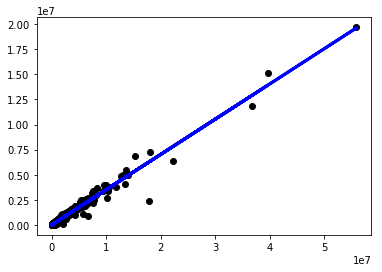

In [61]:
X=verbruik_elektriciteit['sjv_gemiddeld']
Y=verbruik_elektriciteit['gasverbruik']
X = X.reshape(2429, 1)
Y = Y.reshape(2429, 1)
regr = linear_model.LinearRegression().fit(X,Y)
plt.scatter(X, Y,  color='black')
plt.plot(X, regr.predict(X), color='blue', linewidth=3)
plt.show()

In [62]:
source = ColumnDataSource(ColumnDataSource.from_df(verbruik_elektriciteit))
p = figure()
p.scatter(x=verbruik_elektriciteit['sjv_gemiddeld'], y=verbruik_elektriciteit['gasverbruik'], source=source) 
hover = HoverTool()
p.add_tools(hover)
show(p)

C:\Anaconda3\lib\site-packages\bokeh\util\deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)
C:\Anaconda3\lib\site-packages\bokeh\util\deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)


In [63]:
con.close()